A car insurance claim classifier is a business analytics tool designed to analyze and categorize car insurance claims based on various parameters. It utilizes advanced machine learning techniques to automatically process and understand the contents of claim documents, such as accident reports, repair estimates, and customer statements. The primary use case for a car insurance claim classifier is to streamline and optimize the claims management process.

This project had 5 steps :

Importing Libraries

Dataset Analysis

Preprocessing & Feature EDA

Splitting the dataset

Classification model selection and training

In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [137]:
#For Dataset Handling
import pandas as pd
import numpy as np
import re
import sklearn
from sklearn.utils import resample

#For Plotting
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score,accuracy_score,classification_report
import itertools

#For model building
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [112]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [113]:
df_train=pd.read_csv("/content/drive/MyDrive/NEWML/train.csv")

In [ ]:
df_train.head()

,policy_id,policy_tenure,age_of_car,age_of_policyholder,area_cluster,population_density,make,segment,model,fuel_type,...,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating,is_claim
0,ID00001,0.515874,0.05,0.644231,C1,4990,1,A,M1,CNG,...,No,No,No,Yes,No,No,No,Yes,0,0
1,ID00002,0.672619,0.02,0.375000,C2,27003,1,A,M1,CNG,...,No,No,No,Yes,No,No,No,Yes,0,0
2,ID00003,0.841110,0.02,0.384615,C3,4076,1,A,M1,CNG,...,No,No,No,Yes,No,No,No,Yes,0,0
3,ID00004,0.900277,0.11,0.432692,C4,21622,1,C1,M2,Petrol,...,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,2,0
4,ID00005,0.596403,0.11,0.634615,C5,34738,2,A,M3,Petrol,...,No,Yes,Yes,Yes,No,Yes,Yes,Yes,2,0


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58592 entries, 0 to 58591
Data columns (total 44 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   policy_id                         58592 non-null  object 
 1   policy_tenure                     58592 non-null  float64
 2   age_of_car                        58592 non-null  float64
 3   age_of_policyholder               58592 non-null  float64
 4   area_cluster                      58592 non-null  object 
 5   population_density                58592 non-null  int64  
 6   make                              58592 non-null  int64  
 7   segment                           58592 non-null  object 
 8   model                             58592 non-null  object 
 9   fuel_type                         58592 non-null  object 
 10  max_torque                        58592 non-null  object 
 11  max_power                         58592 non-null  object 
 12  engi

In [ ]:
df_train.isnull().sum()

policy_id                           0
policy_tenure                       0
age_of_car                          0
age_of_policyholder                 0
area_cluster                        0
population_density                  0
make                                0
segment                             0
model                               0
fuel_type                           0
max_torque                          0
max_power                           0
engine_type                         0
airbags                             0
is_esc                              0
is_adjustable_steering              0
is_tpms                             0
is_parking_sensors                  0
is_parking_camera                   0
rear_brakes_type                    0
displacement                        0
cylinder                            0
transmission_type                   0
gear_box                            0
steering_type                       0
turning_radius                      0
length      

In [ ]:
df_train.duplicated().sum()

0

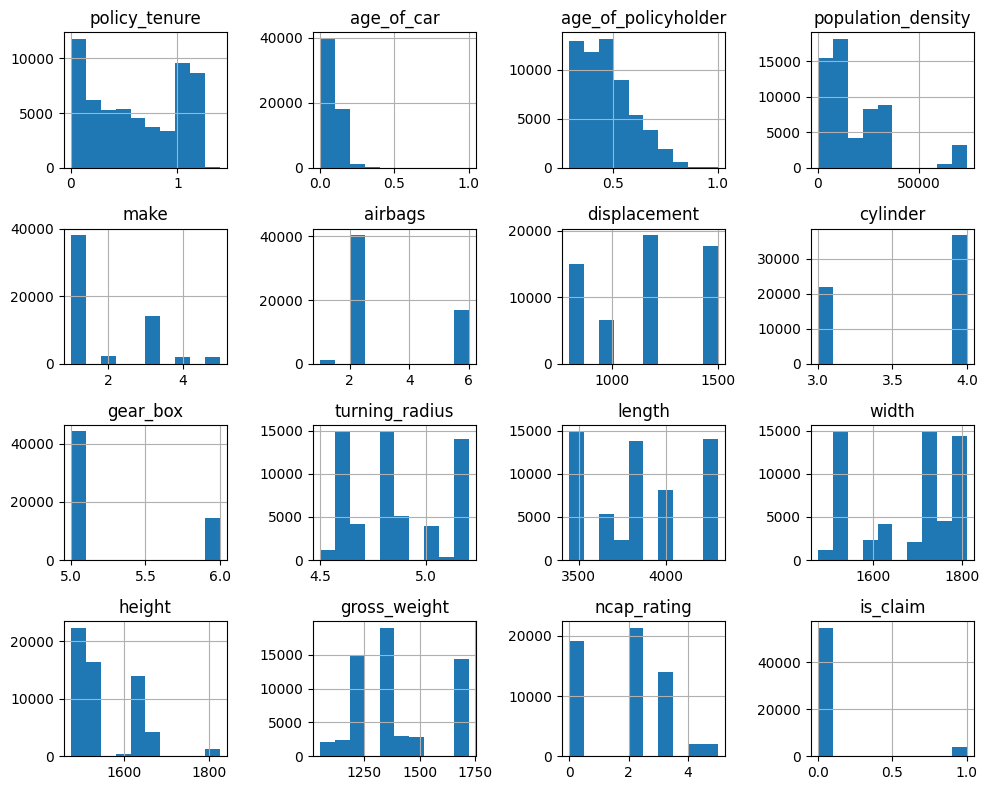

In [ ]:
df_train.hist(figsize=(10,8))
plt.tight_layout()
plt.show()

[Text(0, 2, '54844'), Text(0, 2, '3748')]

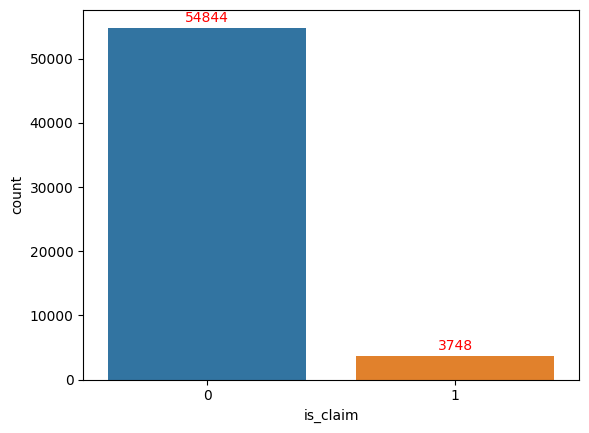

In [ ]:
ss=sns.countplot(data=df_train,x="is_claim");
ss.bar_label(ss.containers[0],padding=2,fontsize=10,color="red")

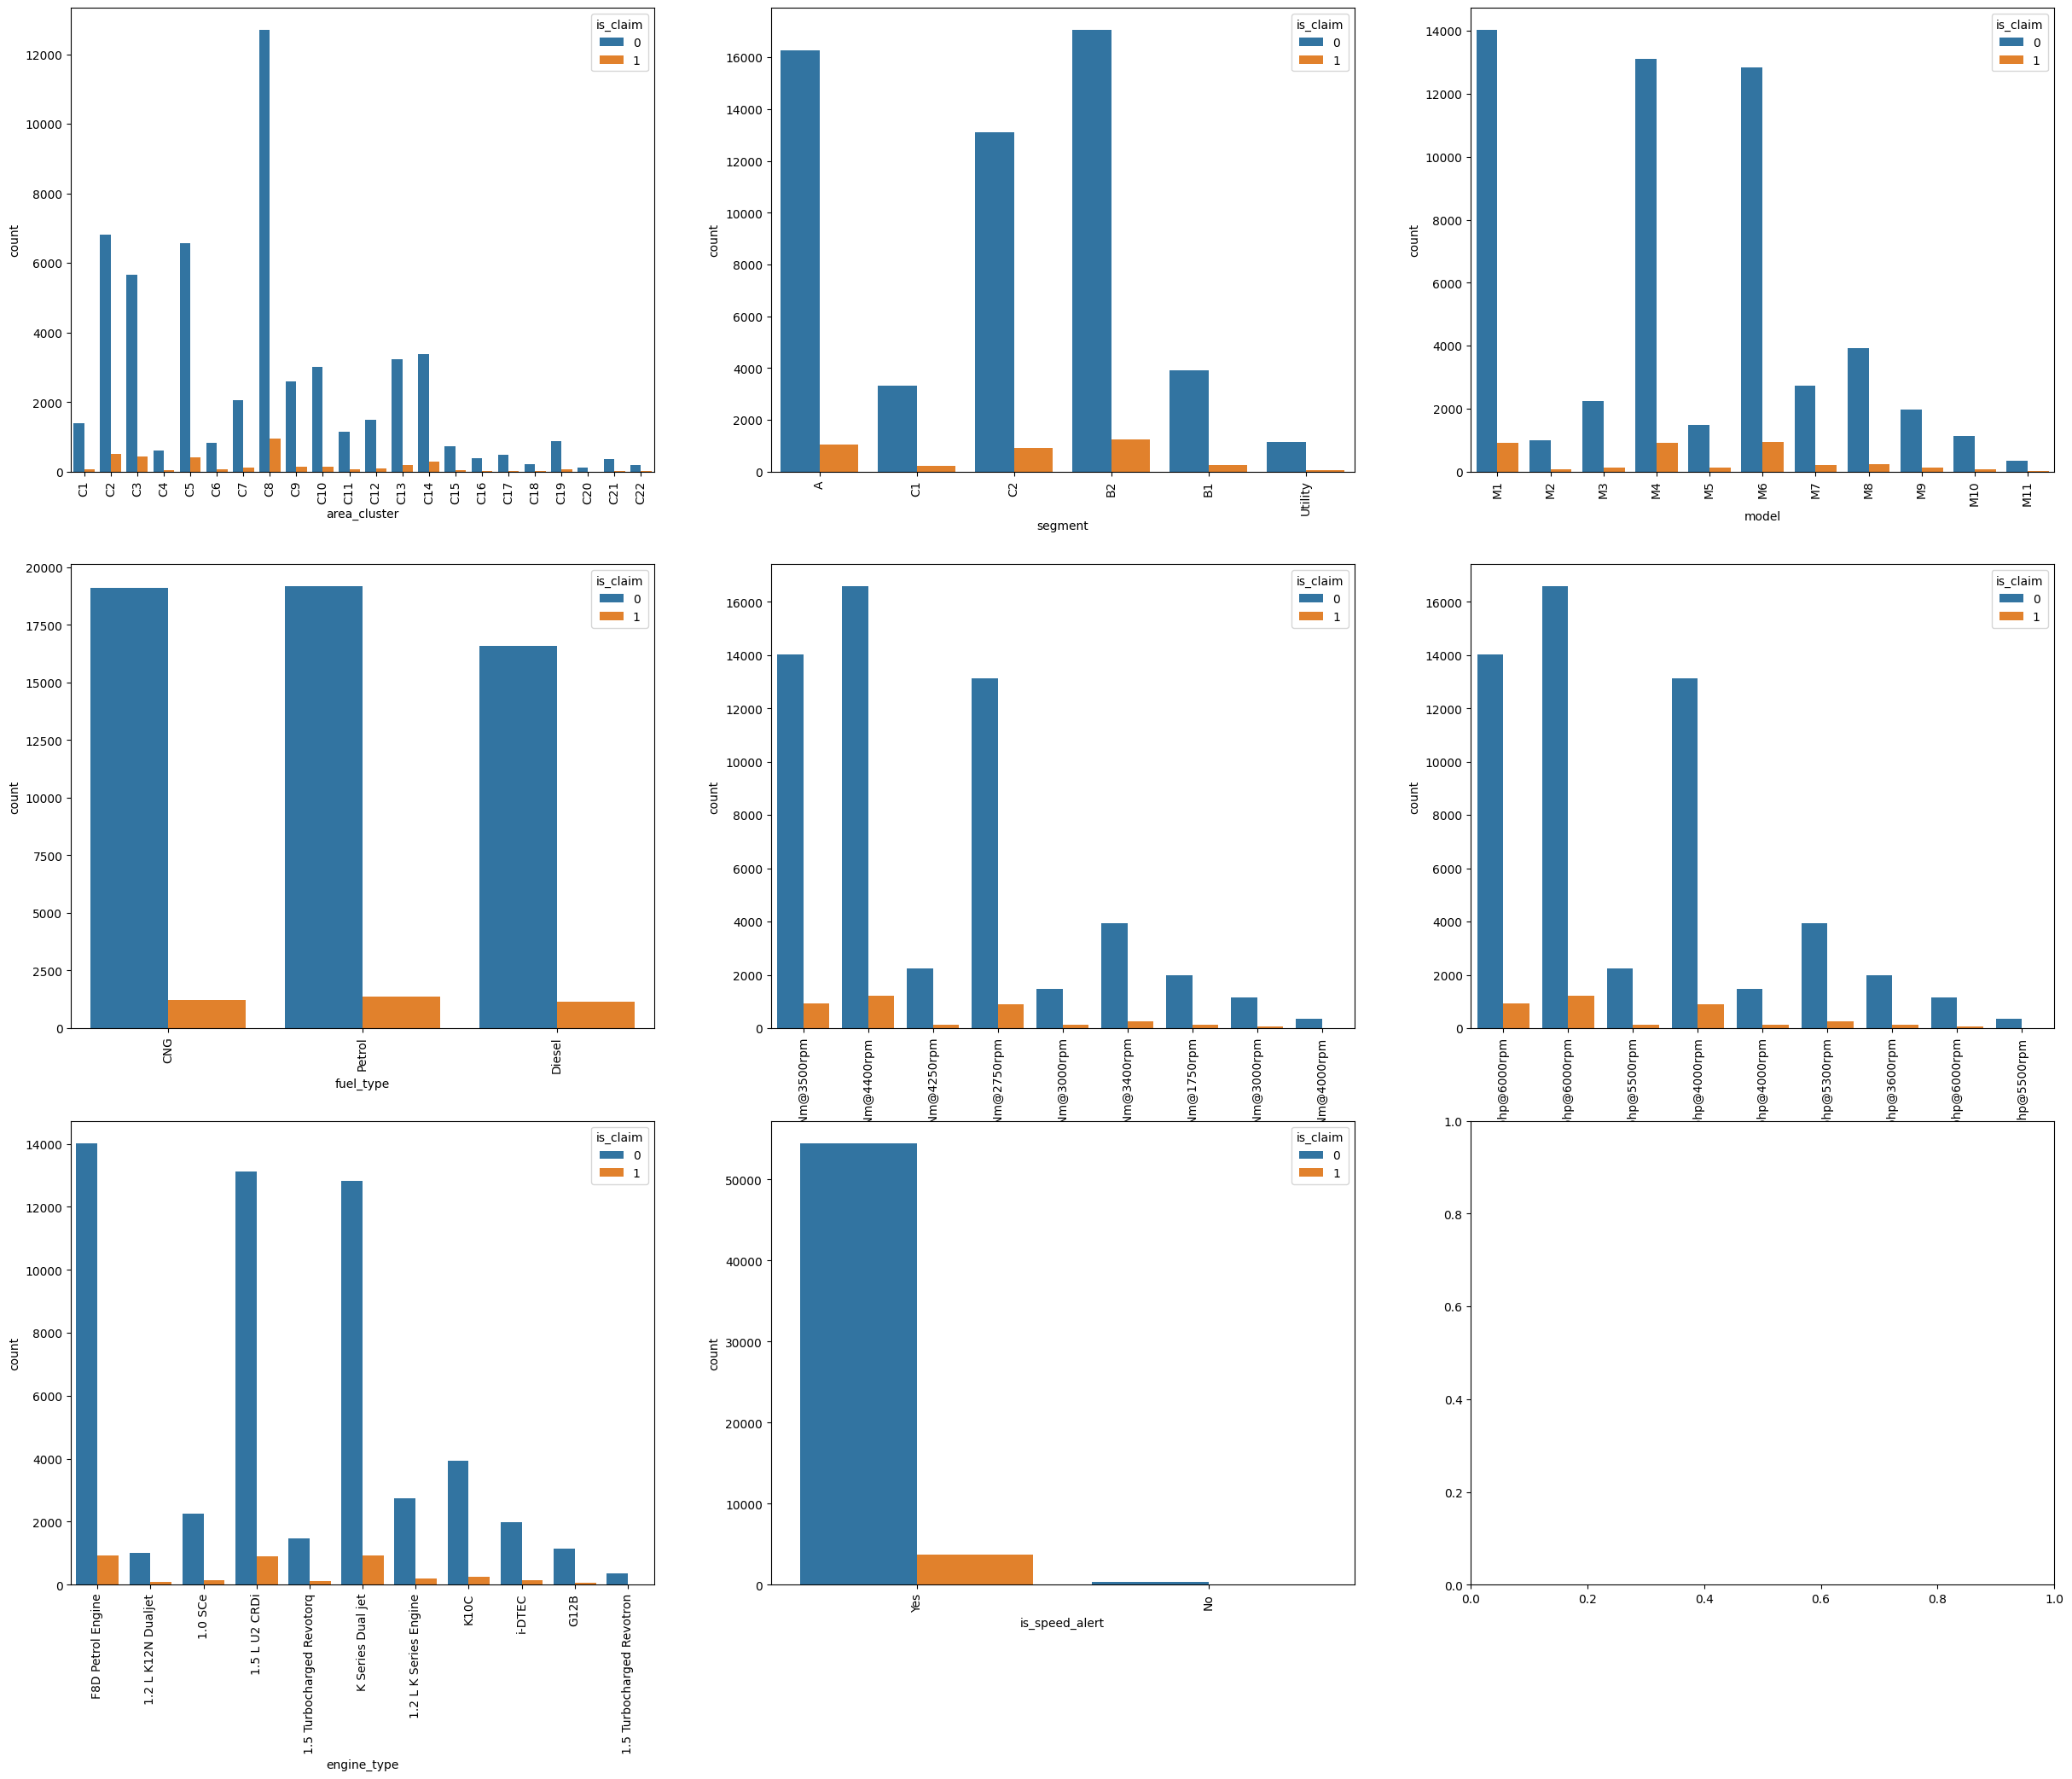

In [ ]:
fig, axes = plt.subplots(3,3, figsize=(30,24))
axes = axes.flatten()

cols_1=['area_cluster', 'segment', 'model', 'fuel_type', 'max_torque','max_power', 'engine_type', 'is_speed_alert']

for i,col in enumerate(cols_1):
    ax=axes[i]
    sns.countplot(data=df_train,x=col,ax=ax,hue="is_claim")
    ax.tick_params(axis='x',rotation=90)
plt.show()


**Observations**

The highest number of claims (about 1000) comes from area C8.


Owners of models M1, M4, and M6 have the highest claims (about 1000 each).


There are zero claims where the speed alert system isn't present in the car.

There are No missing value and 0 duplicate values are present in the data.

There are 44 columns ,float64(4), int64(12), object(28) and 58591 rows.

In [ ]:
df_train['max_torque'].value_counts()

113Nm@4400rpm     17796
60Nm@3500rpm      14948
250Nm@2750rpm     14018
82.1Nm@3400rpm     4173
91Nm@4250rpm       2373
200Nm@1750rpm      2114
200Nm@3000rpm      1598
85Nm@3000rpm       1209
170Nm@4000rpm       363
Name: max_torque, dtype: int64

In [114]:
df_train['torque'] = df_train['max_torque'].apply(lambda x: re.findall(r'\d+\.?\d*(?=Nm)', x)[0])
df_train['rpm'] = df_train['max_torque'].apply(lambda x: re.findall(r'\d+\.?\d*(?=rpm)', x)[0])

# Convert the columns to numeric data type
df_train['torque'] = pd.to_numeric(df_train['torque'])
df_train['rpm'] = pd.to_numeric(df_train['rpm'])

# Calculate torque to RPM ratio
df_train['torque to rpm ratio'] = df_train['torque'] / df_train['rpm']

Bad data are present in the torque so we need to remove it and clean it.

In [ ]:
df_train['torque to rpm ratio'].value_counts()

0.025682    17796
0.017143    14948
0.090909    14018
0.024147     4173
0.021412     2373
0.114286     2114
0.066667     1598
0.028333     1209
0.042500      363
Name: torque to rpm ratio, dtype: int64

In [ ]:
df_train['max_power'].value_counts()

88.50bhp@6000rpm     17796
40.36bhp@6000rpm     14948
113.45bhp@4000rpm    14018
55.92bhp@5300rpm      4173
67.06bhp@5500rpm      2373
97.89bhp@3600rpm      2114
88.77bhp@4000rpm      1598
61.68bhp@6000rpm      1209
118.36bhp@5500rpm      363
Name: max_power, dtype: int64

In [115]:
df_train["bhpp"]=df_train["max_power"].apply(lambda x:re.findall(r'\d+\.?\d*(?=bhp)',x)[0])
df_train["wss"]=df_train["max_power"].apply(lambda x:re.findall(r'\d+\.?\d*(?=rpm)',x)[0])

df_train["bhpp"]=pd.to_numeric(df_train["bhpp"])
df_train["wss"]=pd.to_numeric(df_train["wss"])

df_train["max_powers"]=df_train["bhpp"]/df_train["wss"]

Bad datas are present in max_power need to be cleaned

In [116]:
df_train.drop('max_torque',axis=1,inplace=True)
df_train.drop('torque',axis=1,inplace=True)
df_train.drop('rpm',axis=1,inplace=True)

In [117]:
df_train.drop('bhpp',axis=1,inplace=True)
df_train.drop('wss',axis=1,inplace=True)
df_train.drop('max_power',axis=1,inplace=True)

In [ ]:
df_train["max_powers"]

0        0.006727
1        0.006727
2        0.006727
3        0.014750
4        0.012193
           ...   
58587    0.012193
58588    0.006727
58589    0.006727
58590    0.014750
58591    0.028363
Name: max_powers, Length: 58592, dtype: float64

In [ ]:
df_train.head()

,policy_id,policy_tenure,age_of_car,age_of_policyholder,area_cluster,population_density,make,segment,model,fuel_type,...,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating,is_claim,torque to rpm ratio,max_powers
0,ID00001,0.515874,0.05,0.644231,C1,4990,1,A,M1,CNG,...,No,Yes,No,No,No,Yes,0,0,0.017143,0.006727
1,ID00002,0.672619,0.02,0.375000,C2,27003,1,A,M1,CNG,...,No,Yes,No,No,No,Yes,0,0,0.017143,0.006727
2,ID00003,0.841110,0.02,0.384615,C3,4076,1,A,M1,CNG,...,No,Yes,No,No,No,Yes,0,0,0.017143,0.006727
3,ID00004,0.900277,0.11,0.432692,C4,21622,1,C1,M2,Petrol,...,Yes,Yes,Yes,Yes,Yes,Yes,2,0,0.025682,0.014750
4,ID00005,0.596403,0.11,0.634615,C5,34738,2,A,M3,Petrol,...,Yes,Yes,No,Yes,Yes,Yes,2,0,0.021412,0.012193


<Axes: >

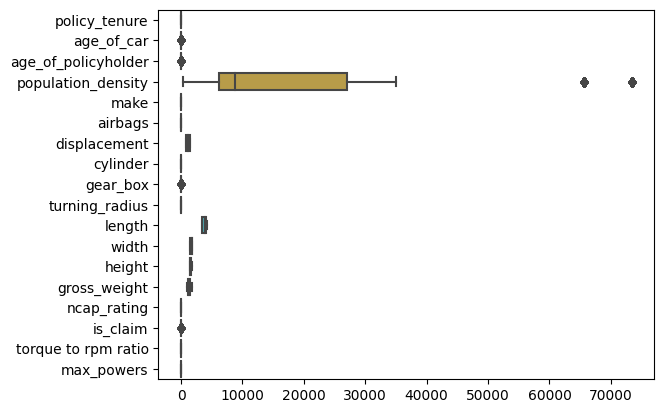

In [ ]:
sns.boxplot(df_train,orient='h')

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58592 entries, 0 to 58591
Data columns (total 44 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   policy_id                         58592 non-null  object 
 1   policy_tenure                     58592 non-null  float64
 2   age_of_car                        58592 non-null  float64
 3   age_of_policyholder               58592 non-null  float64
 4   area_cluster                      58592 non-null  object 
 5   population_density                58592 non-null  int64  
 6   make                              58592 non-null  int64  
 7   segment                           58592 non-null  object 
 8   model                             58592 non-null  object 
 9   fuel_type                         58592 non-null  object 
 10  engine_type                       58592 non-null  object 
 11  airbags                           58592 non-null  int64  
 12  is_e

#One hot enoding converting all categorical into numeric type.

In [121]:
df_train['policy_id'] = df_train['policy_id'].str.extract('(\d+)').astype('int64')

In [118]:
is_cols=[col for col in df_train.columns if col.startswith("is") and col!="is_claim"]
print(is_cols)

['is_esc', 'is_adjustable_steering', 'is_tpms', 'is_parking_sensors', 'is_parking_camera', 'is_front_fog_lights', 'is_rear_window_wiper', 'is_rear_window_washer', 'is_rear_window_defogger', 'is_brake_assist', 'is_power_door_locks', 'is_central_locking', 'is_power_steering', 'is_driver_seat_height_adjustable', 'is_day_night_rear_view_mirror', 'is_ecw', 'is_speed_alert']


In [120]:
df_train = df_train.replace({ "No" : 0 , "Yes" : 1 })

In [ ]:
dataset_num_col = df_train.select_dtypes(include=['int', 'float']).columns
print(" Data Set Numerical columns:")
print(dataset_num_col.nunique())
print(dataset_num_col)

 Data Set Numerical columns:
35
Index(['policy_tenure', 'age_of_car', 'age_of_policyholder',
       'population_density', 'make', 'airbags', 'is_esc',
       'is_adjustable_steering', 'is_tpms', 'is_parking_sensors',
       'is_parking_camera', 'displacement', 'cylinder', 'gear_box',
       'turning_radius', 'length', 'width', 'height', 'gross_weight',
       'is_front_fog_lights', 'is_rear_window_wiper', 'is_rear_window_washer',
       'is_rear_window_defogger', 'is_brake_assist', 'is_power_door_locks',
       'is_central_locking', 'is_power_steering',
       'is_driver_seat_height_adjustable', 'is_day_night_rear_view_mirror',
       'is_ecw', 'is_speed_alert', 'ncap_rating', 'is_claim',
       'torque to rpm ratio', 'max_powers'],
      dtype='object')


In [122]:
dataset_cat_cols = df_train.select_dtypes(include=['object']).columns
print("Data Set categorical columns:")
print(dataset_cat_cols.nunique())
print(dataset_cat_cols)

Data Set categorical columns:
8
Index(['area_cluster', 'segment', 'model', 'fuel_type', 'engine_type',
       'rear_brakes_type', 'transmission_type', 'steering_type'],
      dtype='object')


In [123]:
df_train= pd.get_dummies(df_train, columns=dataset_cat_cols,drop_first=True)

In [ ]:
column=["area_cluster","segment","model","fuel_type","is_esc","is_adjustable_steering","is_tpms","is_parking_sensors","is_parking_camera","rear_brakes_type","transmission_type","steering_type","is_front_fog_lights","is_rear_window_washer","is_rear_window_defogger","is_brake_assist","is_power_door_locks","is_central_locking","is_power_steering","is_driver_seat_height_adjustable","is_day_night_rear_view_mirror","is_ecw","is_speed_alert"]

for i,col in enumerate(column):
    df_train=pd.get_dummies(df_train,columns=[col],drop_first=True)

In [124]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58592 entries, 0 to 58591
Data columns (total 88 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   policy_id                              58592 non-null  int64  
 1   policy_tenure                          58592 non-null  float64
 2   age_of_car                             58592 non-null  float64
 3   age_of_policyholder                    58592 non-null  float64
 4   population_density                     58592 non-null  int64  
 5   make                                   58592 non-null  int64  
 6   airbags                                58592 non-null  int64  
 7   is_esc                                 58592 non-null  int64  
 8   is_adjustable_steering                 58592 non-null  int64  
 9   is_tpms                                58592 non-null  int64  
 10  is_parking_sensors                     58592 non-null  int64  
 11  is

In [ ]:
df_train["policy_id"].value_counts()

ID00001    1
ID39053    1
ID39055    1
ID39056    1
ID39057    1
          ..
ID19535    1
ID19536    1
ID19537    1
ID19538    1
ID58592    1
Name: policy_id, Length: 58592, dtype: int64

In [ ]:
new_df=df_train.select_dtypes(include=["object"])

for new_Df in enumerate(new_df):
    df_train=new_df.astype("int64")

In [125]:
df_train.head()

,policy_id,policy_tenure,age_of_car,age_of_policyholder,population_density,make,airbags,is_esc,is_adjustable_steering,is_tpms,...,engine_type_1.5 Turbocharged Revotron,engine_type_F8D Petrol Engine,engine_type_G12B,engine_type_K Series Dual jet,engine_type_K10C,engine_type_i-DTEC,rear_brakes_type_Drum,transmission_type_Manual,steering_type_Manual,steering_type_Power
0,1,0.515874,0.05,0.644231,4990,1,2,0,0,0,...,0,1,0,0,0,0,1,1,0,1
1,2,0.672619,0.02,0.375000,27003,1,2,0,0,0,...,0,1,0,0,0,0,1,1,0,1
2,3,0.841110,0.02,0.384615,4076,1,2,0,0,0,...,0,1,0,0,0,0,1,1,0,1
3,4,0.900277,0.11,0.432692,21622,1,2,1,1,0,...,0,0,0,0,0,0,1,0,0,0
4,5,0.596403,0.11,0.634615,34738,2,2,0,0,0,...,0,0,0,0,0,0,1,0,0,0


##UNdersampled the target variable because its IMBALANCE

In [126]:
majority_class=df_train[df_train['is_claim']==0]
minority_class=df_train[df_train['is_claim']==1]

# Undersample the majority class
undersampled_majority = resample(
    majority_class,
    replace=False,  # Set to False for undersampling
    n_samples=len(minority_class) * 2,  # Desired number of records in the majority class
    random_state=42  # Set a random seed for reproducibility
)

# Combine the undersampled majority class with the minority class
df_final = pd.concat([undersampled_majority, minority_class])

In [ ]:
df_final["is_claim"].value_counts()

0    7496
1    3748
Name: is_claim, dtype: int64

In [ ]:
df_train["is_claim"].value_counts()

0    54844
1     3748
Name: is_claim, dtype: int64

##Now to check which input features are the least strongly correlated to the target variable 'is_claim', we will plot the correlation heat matrix of the Top 10 least correlated variables available to us.

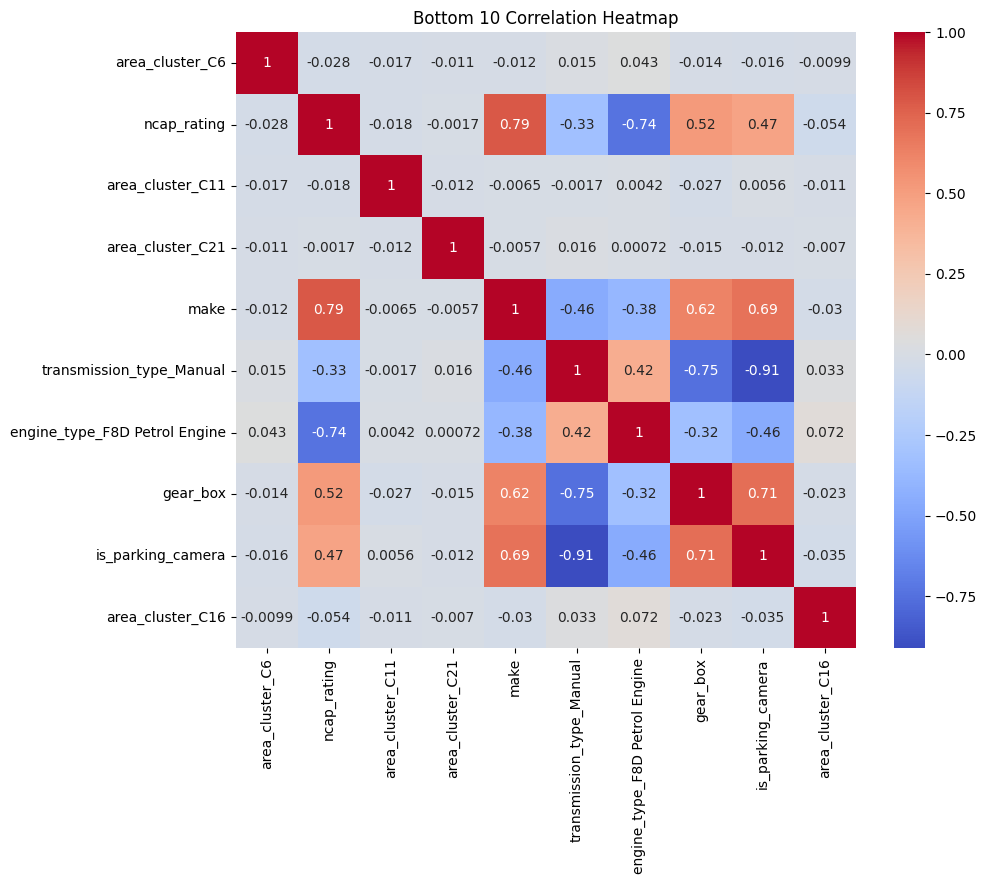

In [127]:
num_bottom_feature=10

correlation_value=df_final.corr()["is_claim"].abs().sort_values(ascending=True)[:num_bottom_feature]

bottom_feature=correlation_value.index

subset_df = df_final[bottom_feature]

correlation_matrix=subset_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title(f'Bottom {num_bottom_feature} Correlation Heatmap')
plt.show()

Upon plotting this map, we can notice that the bottom 3 variables correlated to or affecting the 'is_claim' variable are:

gear_box
is_parking_camera
area_cluster_C16
So our next step will be to drop these bottom 3 variables from our feature vector.

#SPLITTING the dataset

In [128]:
X = df_final.drop(['gear_box','is_parking_camera','area_cluster_C16'], axis=1)
y = df_final['is_claim']  # Target variable

In [129]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

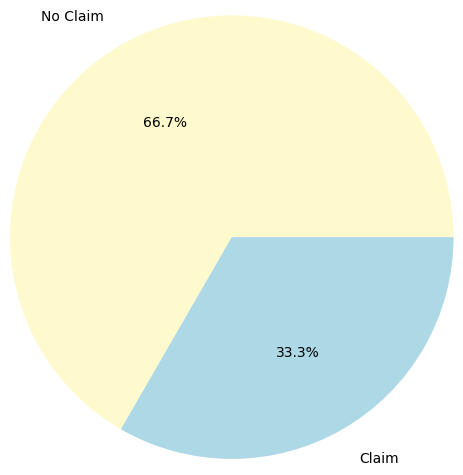

In [ ]:
plt.pie(y.value_counts(),labels=['No Claim','Claim'],radius=1.5,colors = ['#FFFACD','#ADD8E6'],
        autopct='%1.1f%%',labeldistance=1.15,startangle =0)

plt.show()

1)Logistic Regression

In [132]:
log=LogisticRegression()

log.fit(X_train,y_train)

log_test=log.predict(X_test)
log_train=log.predict(X_train)

log_test_accuracy = accuracy_score(y_test,log_test)
log_train_accuracy = accuracy_score(y_train,log_train)

print("the accuracy score of test is :",log_test_accuracy)
print("the accuracy score of train is :",log_train_accuracy)

the accuracy score of test is : 0.670964873277012
the accuracy score of train is : 0.665591995553085


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


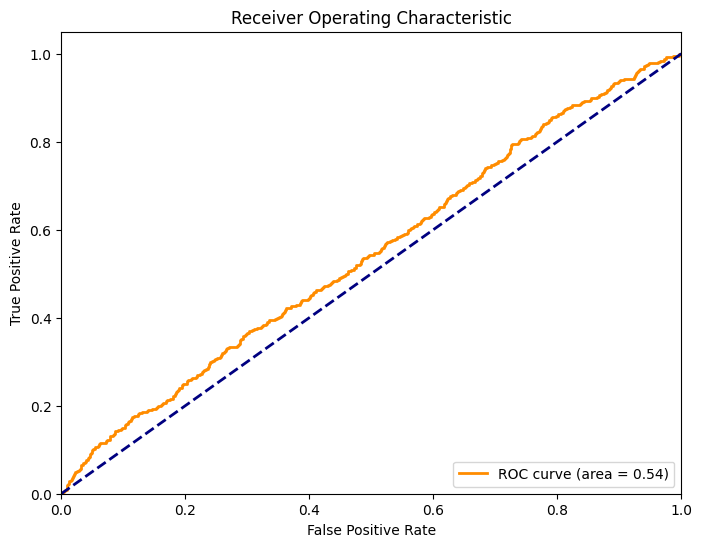

AUC: 0.5442211595293106


In [159]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Calculate the probability scores for the positive class (class 1)
y_test_prob = log.predict_proba(X_test)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)

# Calculate AUC
roc_auc = roc_auc_score(y_test, y_test_prob)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Print AUC
print("AUC:", roc_auc)

##Grid search CV logistic regression.

In [138]:
# Create a Logistic Regression model
model_log = LogisticRegression()

# Define the hyperparameter grid
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

# Create GridSearchCV instance
grid_search_log = GridSearchCV(model_log, param_grid, cv=5, n_jobs=-1)

# Fit the grid search to the data
grid_search_log.fit(X_train, y_train)

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search_log.best_params_)

# Evaluate the best model on the test set
best_model = grid_search_log.best_estimator_

accuracy = best_model.score(X_test, y_test)

log_test_pro=grid_search_log.predict(X_test)
log_train_pro=grid_search_log.predict(X_train)

accuracy_train = best_model.score(X_train, y_train)
print("Accuracy on Test Set:", accuracy)
print("Accuracy on Train Set:", accuracy_train)

print(classification_report(y_test,log_test_pro))

Best Hyperparameters: {'C': 0.001, 'penalty': 'l1', 'solver': 'liblinear'}
Accuracy on Test Set: 1.0
Accuracy on Train Set: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1509
           1       1.00      1.00      1.00       740

    accuracy                           1.00      2249
   macro avg       1.00      1.00      1.00      2249
weighted avg       1.00      1.00      1.00      2249



In [187]:

# Calculate the confusion matrix for the test set
confusion_matrix_test = confusion_matrix(y_test, log_test_pro)

# Print the confusion matrix
print("Confusion Matrix (Test Set):")
print(confusion_matrix_test)

# Calculate the confusion matrix for the training set if needed
confusion_matrix_train = confusion_matrix(y_train, log_train_pro)
print("Confusion Matrix (Training Set):")
print(confusion_matrix_train)


Confusion Matrix (Test Set):
[[1509    0]
 [   0  740]]
Confusion Matrix (Training Set):
[[5987    0]
 [   0 3008]]


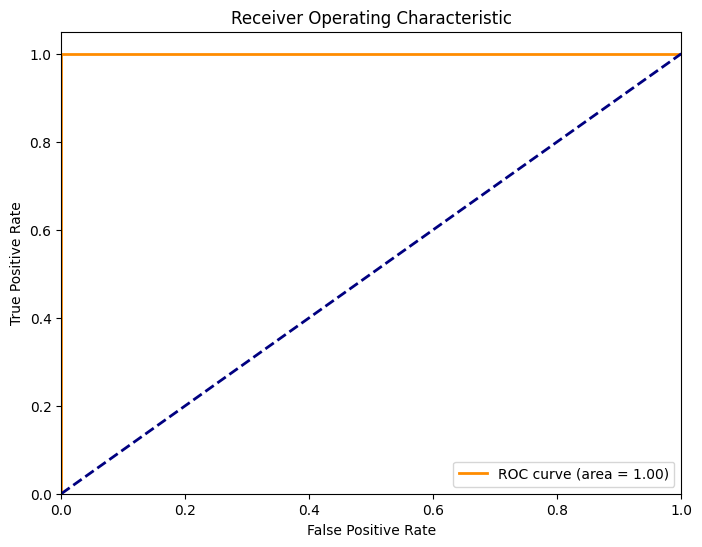

AUC: 1.0


In [161]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
import matplotlib.pyplot as plt

# Get the probability scores for the positive class
y_test_prob = best_model.predict_proba(X_test)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)

# Calculate AUC
roc_auc = roc_auc_score(y_test, y_test_prob)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Print AUC
print("AUC:", roc_auc)

2) RANDOM FOREST

In [144]:
random=RandomForestClassifier()
random.fit(X_train,y_train)

y_pred_test_random=random.predict(X_test)
y_pred_train_Random=random.predict(X_train)

accuracy_test_Random=accuracy_score(y_test,y_pred_test_random)
accuracy_train_Random=accuracy_score(y_train,y_pred_train_Random)

print("the test accuracy is",accuracy_test_Random)
print("the train accuracy is",accuracy_train_Random)

print(classification_report(y_test,y_pred_test_random))

the test accuracy is 1.0
the train accuracy is 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1509
           1       1.00      1.00      1.00       740

    accuracy                           1.00      2249
   macro avg       1.00      1.00      1.00      2249
weighted avg       1.00      1.00      1.00      2249



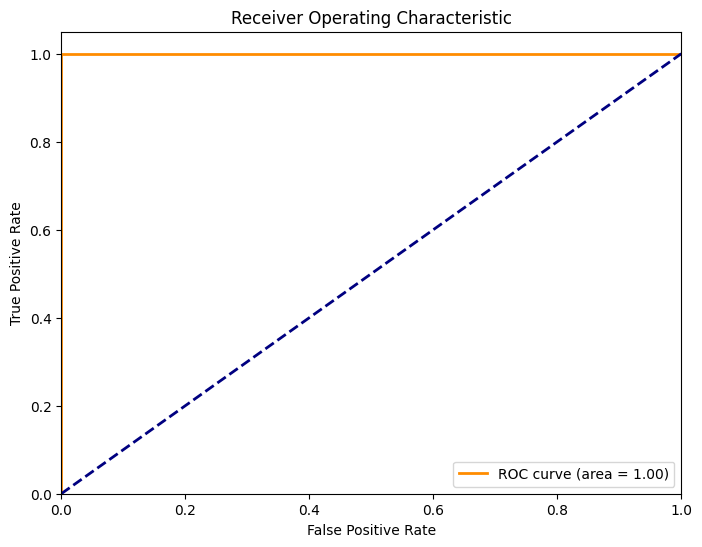

AUC-ROC: 1.0


In [164]:
# Get the probability scores for the positive class
y_test_prob_random = random.predict_proba(X_test)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob_random)

# Calculate AUC-ROC
roc_auc_random = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_random)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Print AUC-ROC
print("AUC-ROC:", roc_auc_random)


In [165]:
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
confusion_mat = confusion_matrix(y_test, y_pred_test_random)

# Print the confusion matrix
print("Confusion Matrix:")
print(confusion_mat)


Confusion Matrix:
[[1509    0]
 [   0  740]]


##Grid search cv randomforest

In [146]:
rf={
    'n_estimators':[100,200,300],
    'max_depth':[None,10,20],
    'min_samples_split':[2,5,10],
    'min_samples_leaf':[1,2,4]
}
ran=RandomForestClassifier()
new_Ran=GridSearchCV(ran,rf,cv=5,n_jobs=-1,scoring='f1')

new_Ran.fit(X_train,y_train)

best_Rf=new_Ran.best_estimator_

y_Ran_test=best_Rf.predict(X_test)
y_Ran_train=best_Rf.predict(X_train)

print("the best parameter are",new_Ran.best_params_)

print(classification_report(y_test, y_Ran_test))



the best parameter are {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1509
           1       1.00      1.00      1.00       740

    accuracy                           1.00      2249
   macro avg       1.00      1.00      1.00      2249
weighted avg       1.00      1.00      1.00      2249



In [166]:
# Calculate the confusion matrix
confusion_mat = confusion_matrix(y_test, y_Ran_test)

# Print the confusion matrix
print("Confusion Matrix:")
print(confusion_mat)


Confusion Matrix:
[[1509    0]
 [   0  740]]


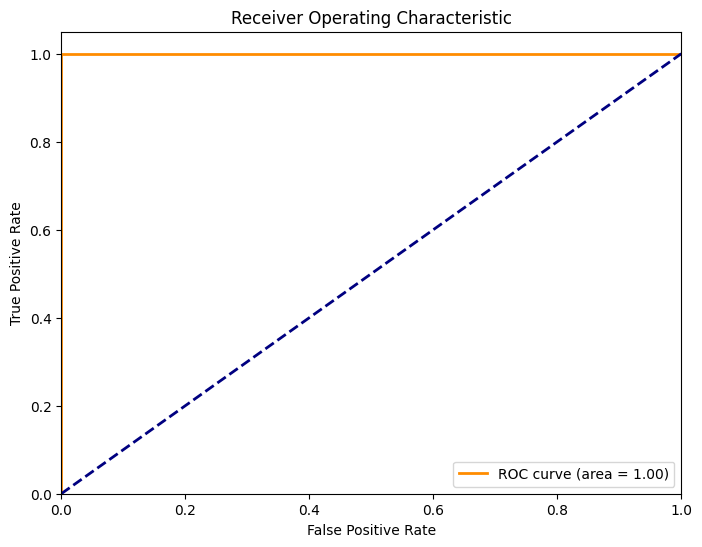

AUC-ROC: 1.0


In [167]:
y_test_prob_Ran = best_Rf.predict_proba(X_test)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob_Ran)

# Calculate AUC-ROC
roc_auc_Ran = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_Ran)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Print AUC-ROC
print("AUC-ROC:", roc_auc_Ran)


3) DECISION TREE

In [148]:
decision=DecisionTreeClassifier()

decision.fit(X_train,y_train)

y_train_decision=decision.predict(X_train)
y_test_decision=decision.predict(X_test)

y_test_acc=accuracy_score(y_test,y_test_decision)
y_train_acc=accuracy_score(y_train,y_train_decision)

print(classification_report(y_test,y_test_decision))

print("the test accuracy is",y_test_acc)
print("the train accuracy is",y_train_acc)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1509
           1       1.00      1.00      1.00       740

    accuracy                           1.00      2249
   macro avg       1.00      1.00      1.00      2249
weighted avg       1.00      1.00      1.00      2249

the test accuracy is 1.0
the train accuracy is 1.0


##GRDI SEARCH CV DECISION TREE

In [153]:
decisi_rf={
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'auto', 'sqrt', 'log2'],
    'class_weight': [None, 'balanced']

}

dec=DecisionTreeClassifier()

new_Dec=GridSearchCV(dec,decisi_rf,cv=5,n_jobs=-1,verbose=2)

new_Dec.fit(X_train,y_train)

new_Dec_1=new_Dec.best_estimator_

y_pred_train_Dec=new_Dec_1.predict(X_train)
y_pred_test_dec=new_Dec_1.predict(X_test)

y_pred_test_decision_Acc=accuracy_score(y_test,y_pred_test_dec)

y_pred_train_decision_Acc=accuracy_score(y_train,y_pred_train_Dec)

print("the accuracy of test is",y_pred_test_decision_Acc)

print('the accuracy of train is',y_pred_train_decision_Acc)

print(classification_report(y_test,y_pred_test_dec))

print("the best parameter",new_Dec.best_params_)


Fitting 5 folds for each of 576 candidates, totalling 2880 fits
the accuracy of test is 1.0
the accuracy of train is 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1509
           1       1.00      1.00      1.00       740

    accuracy                           1.00      2249
   macro avg       1.00      1.00      1.00      2249
weighted avg       1.00      1.00      1.00      2249

the best parameter {'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}


4)KNeighborsClassifier

In [154]:
knn=KNeighborsClassifier()

knn.fit(X_train,y_train)

y_test_knn=knn.predict(X_test)
y_train_knn=knn.predict(X_train)

y_test_Acc=accuracy_score(y_test,y_test_knn)
y_train_Acc=accuracy_score(y_train,y_train_knn)

print("the test accuracy is",y_test_Acc)
print("the train accuracy is",y_train_Acc)

print(classification_report(y_test,y_test_knn))

the test accuracy is 0.6109381947532236
the train accuracy is 0.7292940522512507
              precision    recall  f1-score   support

           0       0.67      0.81      0.74      1509
           1       0.34      0.20      0.25       740

    accuracy                           0.61      2249
   macro avg       0.51      0.51      0.49      2249
weighted avg       0.56      0.61      0.58      2249



In [169]:

# Calculate the confusion matrix
confusion_mat = confusion_matrix(y_test, y_test_knn)

# Print the confusion matrix
print("Confusion Matrix:")
print(confusion_mat)


Confusion Matrix:
[[1229  280]
 [ 595  145]]


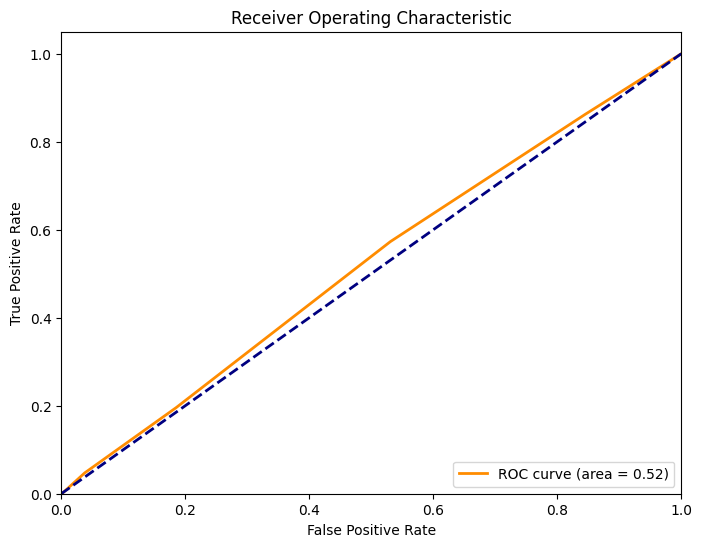

AUC-ROC: 0.5213655006895563


In [170]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
import matplotlib.pyplot as plt

# Get the probability scores for the positive class
y_test_prob_knn = knn.predict_proba(X_test)[:, 1]  # Note: KNN does not have a `predict_proba` method; you may need to use a different classifier for probability scores.

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob_knn)

# Calculate AUC-ROC
roc_auc_knn = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_knn)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Print AUC-ROC
print("AUC-ROC:", roc_auc_knn)


4)GaussianNB

In [155]:
navie = GaussianNB()
navie.fit(X_train,y_train)

navie_train_preds = navie.predict(X_train)
navie_test_preds  = navie.predict(X_test)

navie_test_accuracy=accuracy_score(y_test,navie_test_preds)
navie_train_accuracy=accuracy_score(y_train,navie_train_preds)

print("the accuracy score of test is :",navie_test_accuracy)
print("the accuracy score of train is :",navie_train_accuracy)


the accuracy score of test is : 0.9911071587372166
the accuracy score of train is : 0.9898832684824903


In [171]:
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix for the test set
confusion_matrix_test = confusion_matrix(y_test, navie_test_preds)

# Print the confusion matrix
print("Confusion Matrix (Test Set):")
print(confusion_matrix_test)

# Calculate the confusion matrix for the training set if needed
confusion_matrix_train = confusion_matrix(y_train, navie_train_preds)
print("Confusion Matrix (Training Set):")
print(confusion_matrix_train)


Confusion Matrix (Test Set):
[[1509    0]
 [  20  720]]
Confusion Matrix (Training Set):
[[5987    0]
 [  91 2917]]


#GRID SEARCH CV GaussianNB

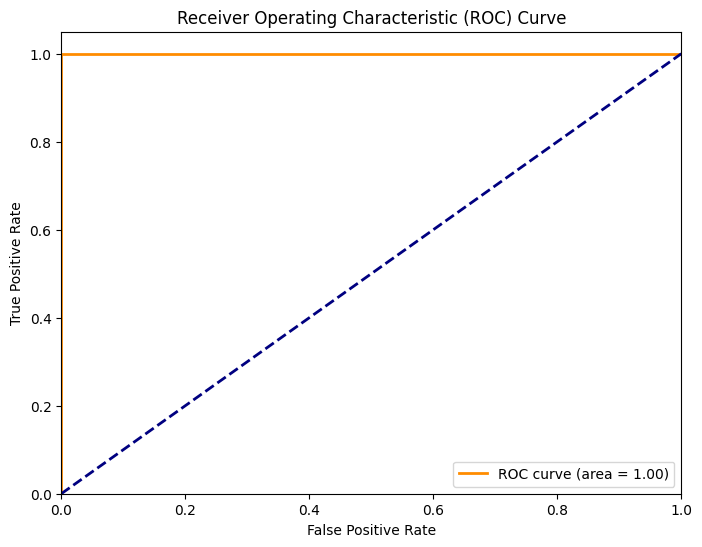

AUC-ROC: 1.0


In [173]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
import matplotlib.pyplot as plt

from sklearn.naive_bayes import GaussianNB

# Create a Gaussian Naive Bayes classifier
navie = GaussianNB()

# Fit the classifier with your training data
navie.fit(X_train, y_train)

# Now you can use predict_proba or make predictions
y_test_prob = navie.predict_proba(X_test)[:, 1]
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)

# Calculate AUC-ROC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Print AUC-ROC
print("AUC-ROC:", roc_auc)


In [156]:
params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}

# Create a k-NN classifier
navie = GaussianNB()

# Perform GridSearchCV with 5-fold cross-validation
gs_NB = GridSearchCV(estimator=navie, param_grid=params_NB, cv=5,verbose=1,scoring='accuracy')
gs_NB.fit(X_train, y_train)

# Print the best hyperparameters found
print("Best hyperparameters:", gs_NB.best_params_)
y_red_test_nb=gs_NB.predict(X_test)
# Evaluate the model on the test set
best_model = gs_NB.best_estimator_
test_accuracy = best_model.score(X_test, y_test)
TRAIN_aCCURACY=best_model.score(X_train, y_train)
print("Test accuracy:", test_accuracy)
print("Train accuracy:",TRAIN_aCCURACY)
print(classification_report(y_test,y_red_test_nb))

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best hyperparameters: {'var_smoothing': 1e-09}
Test accuracy: 0.9911071587372166
Train accuracy: 0.9898832684824903
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1509
           1       1.00      0.97      0.99       740

    accuracy                           0.99      2249
   macro avg       0.99      0.99      0.99      2249
weighted avg       0.99      0.99      0.99      2249



In [174]:
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix for the test set
confusion_matrix_test = confusion_matrix(y_test, y_red_test_nb)

# Print the confusion matrix
print("Confusion Matrix (Test Set):")
print(confusion_matrix_test)

# Calculate the confusion matrix for the training set if needed
confusion_matrix_train = confusion_matrix(y_train, best_model.predict(X_train))
print("Confusion Matrix (Training Set):")
print(confusion_matrix_train)


Confusion Matrix (Test Set):
[[1509    0]
 [  20  720]]
Confusion Matrix (Training Set):
[[5987    0]
 [  91 2917]]


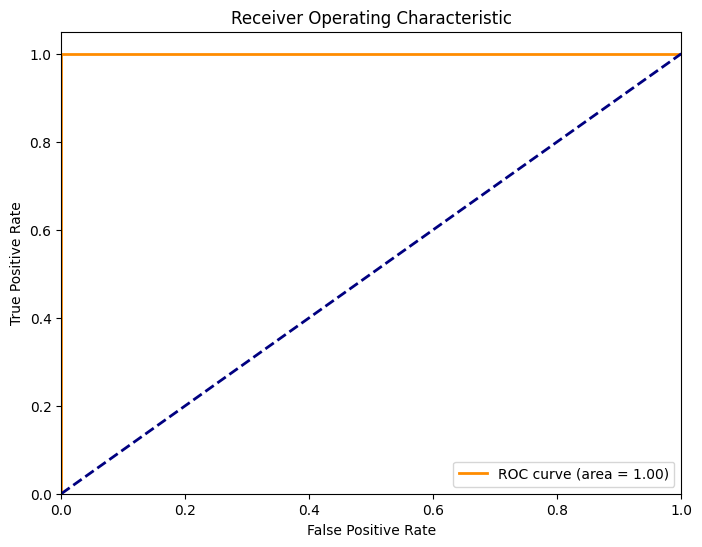

AUC-ROC: 1.0


In [177]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
import matplotlib.pyplot as plt

# Get the probability scores for the positive class (class 1)
y_test_prob_nb = best_model.predict_proba(X_test)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob_nb)

# Calculate AUC-ROC
roc_auc_nb = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_nb)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel ('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Print AUC-ROC
print("AUC-ROC:", roc_auc_nb)


I recommend using the Random Forest model. Here are the insights  based on the Random Forest model's performance:

Insights:

High Accuracy: The Random Forest model achieved a high accuracy of 1.0, indicating that it can effectively classify car insurance claims.

Perfect Classification: The precision, recall, and F1-score are all 1.0 for both classes, suggesting that the model is capable of perfect classification.

No False Positives or Negatives: The confusion matrix shows no false positives or false negatives, which means the model accurately identifies whether a claim is valid or not.

Strong Discriminative Ability: The AUC-ROC score is 1.0, indicating that the model has excellent discriminatory power, making it highly effective in distinguishing between valid and invalid claims.

##Conclusion:

The Random Forest model has demonstrated exceptional classification capabilities and strong discriminative power, making it a highly effective solution for automating the initial assessment of car insurance claims. By implementing the recommendations outlined in this report, we can significantly enhance the efficiency and accuracy of the claims management process, resulting in improved customer satisfaction and operational efficiency.